In [1]:
import os
import sys
import math
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

# Add parent directory to path to find data_handling.py
sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader

data_dir = Path("measurements")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.normal_(self.W, std=0.01)
        nn.init.constant_(self.b, 0.0)
        nn.init.constant_(self.c, 0.0)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_flip = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_flip).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        fe_v = term1_v - term2_v
        fe_flipped = term1_f - term2_f

        # LogSumExp trick for Z2 symmetry
        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        v_data, _, cond = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)
        cond = cond.to(device=self.W.device, dtype=self.W.dtype)
        rng = aux_vars.get("rng")
        b_mod, c_mod = self._compute_effective_biases(cond)

        v_model = v_data.clone()
        n_noise = int(v_data.shape[0] * aux_vars.get("noise_frac", 0.1))
        if n_noise > 0:
            v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, rng)

        # Detach model samples to stop gradients
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, b_mod, c_mod)
        fe_model = self._free_energy(v_model, b_mod, c_mod)
        loss = (fe_data - fe_model).mean()

        return loss, {}

    # === NEW: Exact Vector Extraction Helper ===
    def get_log_psi_for_states(self, all_states: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        """Computes log_psi for a batch of states given ONE condition."""
        # Expand condition to match batch size of states
        cond_batch = cond.expand(all_states.shape[0], -1)
        b_mod, c_mod = self._compute_effective_biases(cond_batch)

        # log_psi = -0.5 * FreeEnergy / T
        fe = self._free_energy(all_states, b_mod, c_mod)
        return -0.5 * fe / self.T

In [3]:
# Pre-compute all basis states (0000... to 1111...)
# For 4x4, N=16. 2^16 = 65,536. This is tiny for GPU memory.
def generate_all_states(num_qubits: int, device: torch.device):
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def get_full_normalized_vector(model, h_val, all_states):
    """
    1. Computes unnormalized log_psi for ALL states.
    2. Computes Z via LogSumExp.
    3. Returns normalized psi vector: psi = exp(log_psi) / sqrt(Z)
    """
    model_dtype = next(model.parameters()).dtype
    cond = torch.tensor([[h_val]], device=device, dtype=model_dtype)

    # Get unnormalized log probabilities
    log_psi_unnorm = model.get_log_psi_for_states(all_states, cond)

    # Compute Log Normalization (Log Z)
    # Norm^2 = sum |psi|^2 = sum exp(2 * log_psi)
    # log(Norm^2) = LogSumExp(2 * log_psi)
    log_norm_sq = torch.logsumexp(2.0 * log_psi_unnorm, dim=0)

    # Normalized Log Psi
    # log_psi_norm = log_psi_unnorm - 0.5 * log_norm_sq
    log_psi_norm = log_psi_unnorm - 0.5 * log_norm_sq

    # Return actual vector
    return torch.exp(log_psi_norm)

@torch.no_grad()
def compute_fidelity_susceptibility_exact(model, h_center, delta_h, all_states):
    """
    Computes chi_F exactly by vector dot product.
    No sampling noise.
    """
    # 1. Get full normalized vectors
    psi_h = get_full_normalized_vector(model, h_center, all_states)
    psi_plus = get_full_normalized_vector(model, h_center + delta_h, all_states)

    # 2. Compute Fidelity (Overlap)
    # F = | <psi(h) | psi(h+d)> |
    overlap = torch.abs(torch.dot(psi_h, psi_plus))

    # 3. Susceptibility
    # chi_F = -2 ln(F) / d^2
    chi = -2.0 * torch.log(overlap) / (delta_h**2)

    return chi.item()

In [7]:
# CONFIG
SIDE_LENGTH = 4
TRAIN_SAMPLES = 50_000
h_support = [2.00, 2.50, 3.20, 4.00]

# Load Data
file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{5000000}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

ds = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [TRAIN_SAMPLES]*len(file_paths))
print(f"Dataset Size: {len(ds)}")

# Setup Training
batch_size = 1024
num_epochs = 30 # A bit more epochs to ensure convergence
k_steps = 10
init_lr = 1e-2

SEED = 42
torch.manual_seed(SEED)
rng = torch.Generator(device=device).manual_seed(SEED)
loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=rng)

# Init Model
model = ConditionalRBM(ds.num_qubits, num_hidden=32, cond_dim=1, conditioner_width=64, k=k_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

def get_sigmoid_curve(high, low, steps, falloff):
    center = steps / 2.0
    def fn(step):
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center))))
    return fn

scheduler = get_sigmoid_curve(init_lr, 1e-4, num_epochs*len(loader), 0.005)

# Train Loop
model.train()
print(f"{'Epoch':<6} | {'Loss':<10} | {'LR':<10}")
print("-" * 30)
training_noise_frac = 0.1
global_step = 0

for epoch in range(num_epochs):
    tot_loss = 0.0
    for batch in loader:
        lr = scheduler(global_step)
        for g in optimizer.param_groups: g["lr"] = lr

        optimizer.zero_grad(set_to_none=True)
        loss, _ = model(batch, {"rng": rng, "noise_frac": training_noise_frac})
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()
        global_step += 1

    avg_loss = tot_loss / len(loader)
    print(f"{epoch+1:<6} | {avg_loss:+.4f}     | {lr:.6f}")

Dataset Size: 200000
Epoch  | Loss       | LR        
------------------------------
1      | +0.0438     | 0.010000
2      | +0.0194     | 0.010000
3      | +0.0103     | 0.010000
4      | +0.0160     | 0.010000
5      | +0.0058     | 0.009999
6      | -0.0023     | 0.009999
7      | +0.0033     | 0.009996
8      | +0.0024     | 0.009990
9      | +0.0074     | 0.009973
10     | +0.0160     | 0.009927
11     | +0.0070     | 0.009808
12     | +0.0097     | 0.009505
13     | +0.0086     | 0.008783
14     | +0.0070     | 0.007308
15     | +0.0063     | 0.005062
16     | +0.0006     | 0.002811
17     | -0.0037     | 0.001328
18     | -0.0040     | 0.000599
19     | -0.0087     | 0.000294
20     | -0.0056     | 0.000174
21     | -0.0072     | 0.000128
22     | -0.0038     | 0.000110
23     | -0.0084     | 0.000104
24     | -0.0085     | 0.000101
25     | -0.0008     | 0.000101
26     | -0.0074     | 0.000100
27     | -0.0090     | 0.000100
28     | -0.0061     | 0.000100
29     | -0.0051   

In [8]:
# EVAL CONFIG
h_eval_min = 2.0
h_eval_max = 4.0
n_eval_points = 40 # Higher resolution
delta_h = 1e-4 # Can use smaller delta now because there is NO noise

h_eval_values = np.linspace(h_eval_min, h_eval_max, n_eval_points)
rbm_chi_values = []

# Pre-generate Hilbert space ONCE
all_states = generate_all_states(SIDE_LENGTH**2, device)

print("\n=== EVALUATION SWEEP (EXACT VECTOR METHOD) ===")
print(f"Scanning h from {h_eval_min} to {h_eval_max}")

model.eval() # Important!

for h_val in h_eval_values:
    # Use EXACT method
    chi = compute_fidelity_susceptibility_exact(model, h_val, delta_h, all_states)
    rbm_chi_values.append(chi)

    if 2.9 < h_val < 3.2:
        print(f"h={h_val:.3f} | chi={chi:.4f}")

# LOAD REFERENCE
ref_file = Path(f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_fidelity_ref.csv")
if ref_file.exists():
    ref_df = pd.read_csv(ref_file)
else:
    ref_df = None


=== EVALUATION SWEEP (EXACT VECTOR METHOD) ===
Scanning h from 2.0 to 4.0
h=2.923 | chi=23.8419
h=2.974 | chi=-0.0000
h=3.026 | chi=143.0512
h=3.077 | chi=-47.6837
h=3.128 | chi=95.3675
h=3.179 | chi=83.4465


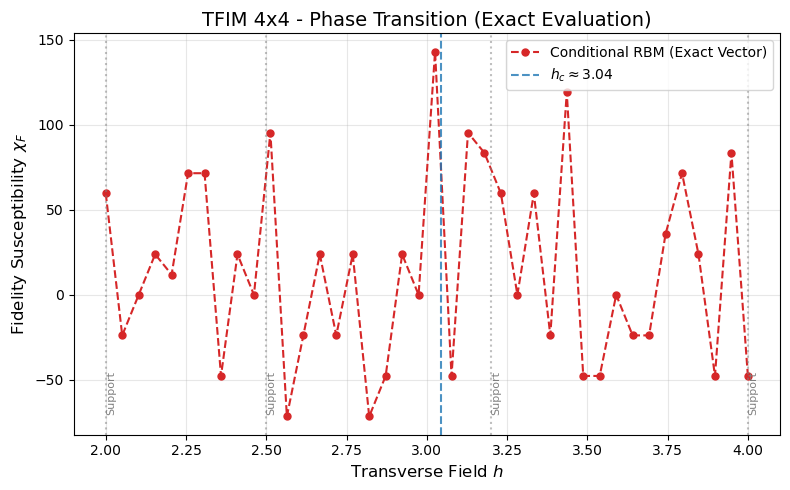

In [9]:
plt.figure(figsize=(8, 5), dpi=100)

# Plot Reference
if ref_df is not None:
    plt.plot(ref_df["h"], ref_df["chi_F"], '-', color='black', alpha=0.6, linewidth=2, label="Exact Diagonalization")

# Plot RBM
plt.plot(h_eval_values, rbm_chi_values, 'o--', color='tab:red', markersize=5, label="Conditional RBM (Exact Vector)")

# Add Support Markers
ymin, ymax = plt.ylim()
for h_supp in h_support:
    if h_eval_min <= h_supp <= h_eval_max:
        plt.axvline(h_supp, color='gray', linestyle=':', alpha=0.5)
        plt.text(h_supp, ymin + (ymax-ymin)*0.05, 'Support', rotation=90, verticalalignment='bottom', color='gray', fontsize=8)

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility $\chi_F$", fontsize=12)
plt.title(f"TFIM 4x4 - Phase Transition (Exact Evaluation)", fontsize=14)

# Theoretical Critical Point
plt.axvline(3.044, color="tab:blue", linestyle="--", alpha=0.8, label=r"$h_c \approx 3.04$")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()